In [1]:
#second imports section (switch environment here)
import pandas as pd
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

#load aml public data and signatures and clean data
clinical_df = pd.read_csv('data/signatures/laml_tcga_clinical.tsv', sep='\t', comment='#', index_col = 'PATIENT_ID')
expr_df = pd.read_csv('data/signatures/laml_tcga_expression.tsv', sep='\t', index_col=0)
expr_df = expr_df.drop(columns=['Entrez_Gene_Id'])

plps_genes = pd.read_csv('data/signatures/plps.csv')['Gene'].tolist()
stem11_genes = pd.read_csv('data/signatures/stem11.csv')['Gene'].tolist()
clinical_df = clinical_df[~clinical_df.index.duplicated(keep='first')]
expr_df = expr_df.loc[:, ~expr_df.columns.duplicated(keep='first')]

clinical_df.index = clinical_df.index.str[:12]
expr_df.columns = expr_df.columns.str[:12]

expr_df.replace([np.inf, -np.inf], np.nan, inplace=True)
expr_df.fillna(0, inplace=True)

/home/naraenpc/envs/preleuk_env2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#calculate signature scores
plps_net = pd.DataFrame({'source': 'PLPS', 'target': plps_genes, 'weight': 1})
stem11_net = pd.DataFrame({'source': 'Stem11', 'target': stem11_genes, 'weight': 1})
signature_net = pd.concat([plps_net, stem11_net], ignore_index = True)

In [ ]:
#run the wmean function and capture its output
expr_df = expr_df.groupby(level=0).mean() #removes duplicates in mat layer

patient_scores_df = dc.run_wmean(
    mat = expr_df.T,
    net = signature_net,
    source = 'source',
    target = 'target',
    weight = 'weight',
    min_n = 5
)
patient_scores_df = patient_scores_df[0]

In [5]:
#prepare data for survival analysis
survival_df = clinical_df.join(patient_scores_df, how='inner')
time_col = 'OS_MONTHS'
event_col = 'OS_STATUS'
survival_df[time_col] = pd.to_numeric(survival_df[time_col], errors='coerce')
survival_df[event_col] = (survival_df[event_col] == '1:DECEASED').astype(int)
survival_df.dropna(subset=[time_col, event_col], inplace=True)

Log-rank test p-value: 0.8430


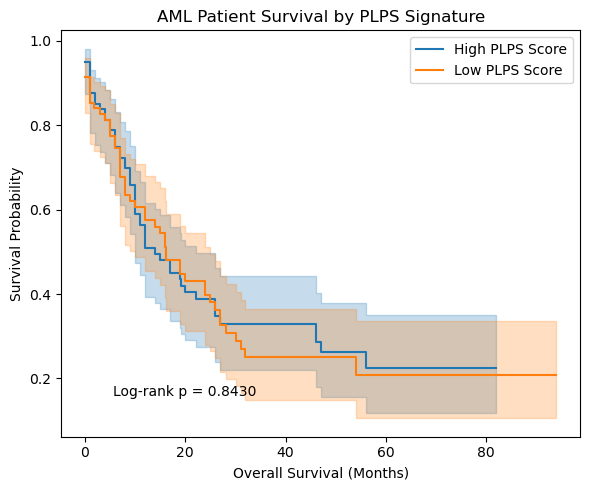

Log-rank test p-value: 0.1106


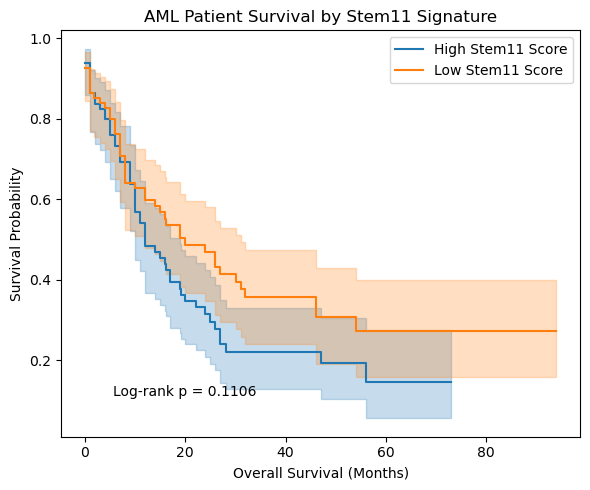

In [6]:
#stratification analysis function
def run_stratification_analysis(signature_name, survival_data, time_column, event_column):
    survival_data = survival_data[[time_column, event_column, signature_name]].dropna()
    
    median_score = survival_data[signature_name].median()
    survival_data[f'{signature_name}_group'] = ['High' if score > median_score else 'Low' for score in survival_data[signature_name]]

    T = survival_data[time_column]
    E = survival_data[event_column]
    groups = survival_data[f'{signature_name}_group']
    high_mask = (groups == 'High')
    low_mask = (groups == 'Low')

    results = logrank_test(T[high_mask], T[low_mask], event_observed_A=E[high_mask], event_observed_B=E[low_mask])
    p_value = results.p_value
    print(f"Log-rank test p-value: {p_value:.4f}")

    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    kmf.fit(T[high_mask], event_observed=E[high_mask], label=f'High {signature_name} Score')
    kmf.plot_survival_function(ax=ax)

    kmf.fit(T[low_mask], event_observed=E[low_mask], label=f'Low {signature_name} Score')
    kmf.plot_survival_function(ax=ax)

    ax.set_title(f'AML Patient Survival by {signature_name} Signature')
    ax.set_xlabel('Overall Survival (Months)')
    ax.set_ylabel('Survival Probability')
    ax.text(0.1, 0.1, f'Log-rank p = {p_value:.4f}', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.savefig(f'preleuk_dashboard/plots/{signature_name}_survival_plot.png', dpi=300)
    plt.show()

run_stratification_analysis('PLPS', survival_df.copy(), time_col, event_col)
run_stratification_analysis('Stem11', survival_df.copy(), time_col, event_col)